## Phase 3 Project
Michal Ostrowski

In [75]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import folium
import matplotlib.image as mpimg
import io
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LogisticRegression

In [76]:
# Load the dataset
Telecomdf = pd.read_csv("bigml_59c28831336c6604c800002a.csv")

## Data cleaning

In [77]:
#Looking for null values
print(Telecomdf.isnull().sum())

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64


In [78]:
#No values appear to be null in the above cell

In [79]:
#Editing column names
Telecomdf = Telecomdf.rename(columns={'international plan': 'international_plan', 'voice mail plan': 'voice_mail_plan'})

In [80]:
#Looking for duplicates
print(Telecomdf.duplicated().sum())

0


No duplicates are present

In [81]:
#making alphabetical values numerical
Telecomdf['international_plan'] = np.where(Telecomdf['international_plan'] == 'yes', 1, 0)
Telecomdf['voice_mail_plan'] = np.where(Telecomdf['voice_mail_plan'] == 'yes', 1, 0)

In [82]:
Telecomdf['churn'] = Telecomdf['churn'].astype(str).replace({'True': 1, 'False': 0})

In [83]:
#creating a new column with total charges
Telecomdf = Telecomdf.assign(total_charge=lambda x: x['total day charge'] + x['total eve charge'] + x['total night charge'] + x['total intl charge'])

## Starting Data Analysis

In [84]:
print(Telecomdf.describe())

       account length    area code  international_plan  voice_mail_plan  \
count     3333.000000  3333.000000         3333.000000      3333.000000   
mean       101.064806   437.182418            0.096910         0.276628   
std         39.822106    42.371290            0.295879         0.447398   
min          1.000000   408.000000            0.000000         0.000000   
25%         74.000000   408.000000            0.000000         0.000000   
50%        101.000000   415.000000            0.000000         0.000000   
75%        127.000000   510.000000            0.000000         1.000000   
max        243.000000   510.000000            1.000000         1.000000   

       number vmail messages  total day minutes  total day calls  \
count            3333.000000        3333.000000      3333.000000   
mean                8.099010         179.775098       100.435644   
std                13.688365          54.467389        20.069084   
min                 0.000000           0.000000     

In [85]:
# Define the regression formula
formula = 'churn ~ international_plan + voice_mail_plan'

# Fit the regression model
model = smf.ols(formula, data=Telecomdf).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     141.4
Date:                Mon, 09 Jan 2023   Prob (F-statistic):           1.14e-59
Time:                        20:23:13   Log-Likelihood:                -1113.6
No. Observations:                3333   AIC:                             2233.
Df Residuals:                    3330   BIC:                             2251.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1375      0

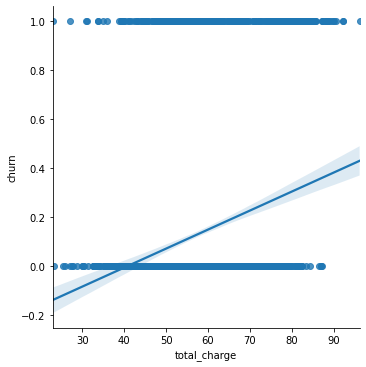

In [97]:
sns.lmplot(x='total_charge', y='churn', data=Telecomdf)

In [110]:
# Fit a multiple linear regression model
model = smf.ols(formula='total_charge ~ churn', data=Telecomdf).fit()

# Make predictions for a range of churn values
churn_range = pd.DataFrame({'churn': np.linspace(Telecomdf['churn'].min(), Telecomdf['churn'].max(), 100)})
predictions = model.predict(churn_range)

# Find the churn value where the predicted total_charge is minimized
min_index = predictions.idxmin()
min_churn = churn_range.iloc[min_index]['churn']

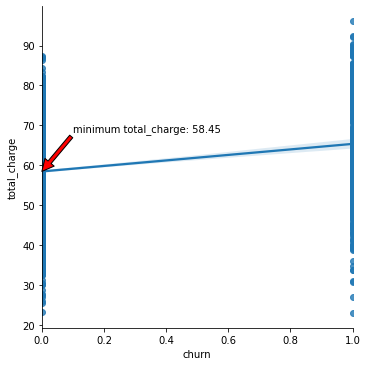

In [111]:
# Create a scatter plot with a multiple linear regression line
sns.lmplot(x='churn', y='total_charge', data=Telecomdf)

# Find the churn value where the predicted total_charge is minimized
min_index = predictions.idxmin()
min_churn = churn_range.iloc[min_index]['churn']

# Annotate the plot with the minimum total_charge and churn values
plt.annotate(f'minimum total_charge: {predictions[min_index]:.2f}', xy=(min_churn, predictions[min_index]), xytext=(min_churn + 0.1, predictions[min_index] + 10), arrowprops={'facecolor': 'red'})

# Label the axes
plt.xlabel('churn')
plt.ylabel('total_charge')

# Show the plot
plt.show()

At this point I see that the point in dollars where people drew the line of when they would cancel.  that price was 58.45 dollars.
seeing this My first recommendation is going to be to create a monthly plan and charge 50.00 dollars


In [112]:
Telecomdf

,state,account length,area code,phone number,international_plan,voice_mail_plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_charge
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,16.78,244.7,91,11.01,10.0,3,2.70,1,0,75.56
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,16.62,254.4,103,11.45,13.7,3,3.70,1,0,59.24
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,10.30,162.6,104,7.32,12.2,5,3.29,0,0,62.29
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,5.26,196.9,89,8.86,6.6,7,1.78,2,0,66.80
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,12.61,186.9,121,8.41,10.1,3,2.73,3,0,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,0,1,36,156.2,77,26.55,...,18.32,279.1,83,12.56,9.9,6,2.67,2,0,60.10
3329,WV,68,415,370-3271,0,0,0,231.1,57,39.29,...,13.04,191.3,123,8.61,9.6,4,2.59,3,0,63.53
3330,RI,28,510,328-8230,0,0,0,180.8,109,30.74,...,24.55,191.9,91,8.64,14.1,6,3.81,2,0,67.74
3331,CT,184,510,364-6381,1,0,0,213.8,105,36.35,...,13.57,139.2,137,6.26,5.0,10,1.35,2,0,57.53


In [114]:
#create a column for the churn rate by dividing the number of churned accounts by the total number of accounts at each point in time
Telecomdf['churn_rate'] = Telecomdf.groupby('account length')['churn'].apply(lambda x: x.sum() / len(x))

<AxesSubplot:xlabel='account length', ylabel='churn_rate'>

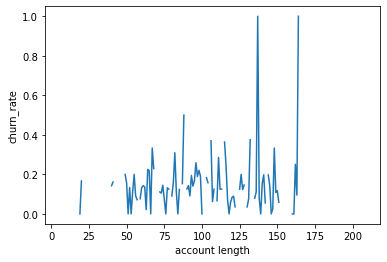

In [116]:
# plot the churn rate on the y-axis and the account length on the x-axis
sns.lineplot(x='account length', y='churn_rate', data=Telecomdf)

<AxesSubplot:xlabel='account length', ylabel='churn_rate'>

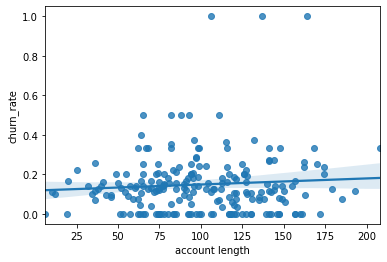

In [118]:
sns.regplot(x='account length', y='churn_rate', data=Telecomdf)